Copyright (c) 2023, NVIDIA CORPORATION & AFFILIATES

SPDX-License-Identifier: BSD-3-Clause

In this notebook we will go over some examples on how to use `cuquantum-python` to execute some MPS algorithms for quantum circuit simulation. 

This notebook will guide you through the following tasks:
 - I. Initializing an entangled quantum circuit as a basis.
 - II. Constructing an MPS from a quantum circuit and verifying its correctness.
 - III. Computing the expectation value of an MPS, with and without canonicalization.
 - IV. Performing MPS-MPO multiplication using two different methods and assessing their accuracy for the approximations.

Note that we will use `cupy.ndarray` for operands throughout this notebook.

In [1]:
import cupy as cp
import numpy as np

from cuquantum import contract, contract_path, CircuitToEinsum, tensor
from cuquantum import cutensornet as cutn
from cuquantum.cutensornet.experimental import contract_decompose

np.random.seed(0)
cp.random.seed(0)

# We will reuse library handle in this notebook to reduce the context initialization time.
handle = cutn.create()
options = {'handle': handle}

# I. Generate an Entangled Circuit

Here we start with a parameterized, entangled circuit as our basis for MPS simulation. 

This can be easily achieved using the `TwoLocal` class in `qiskit` or by providing a customized generator to `cirq.Circuit`.

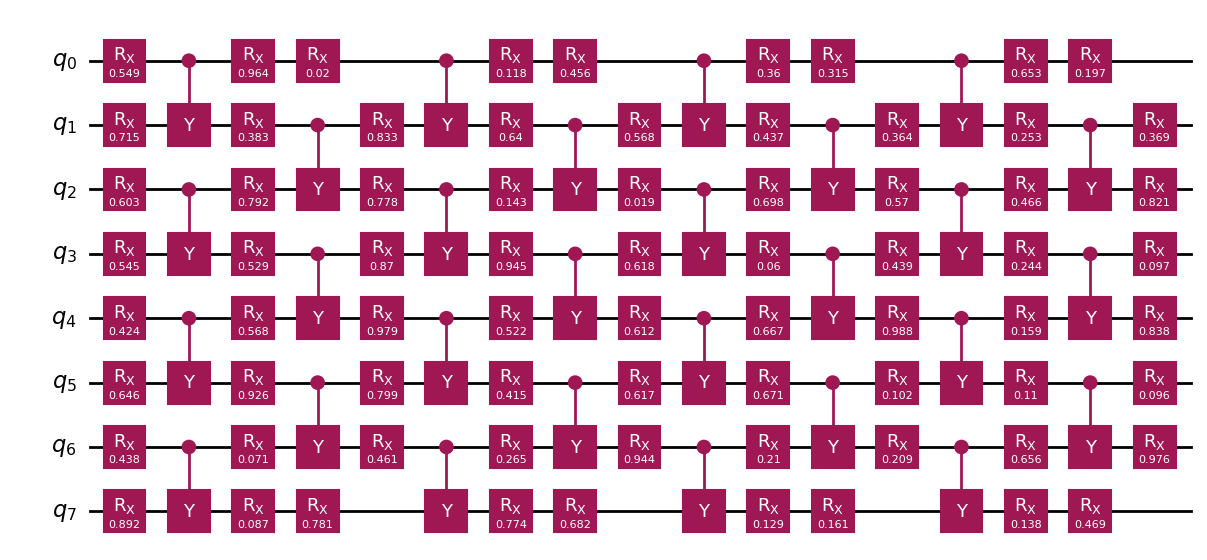

In [2]:
def get_entangled_circuit(num_qubits, reps, backend):
    """
    Create an entangled circuit for the given number of qubits and repetitions (layers).
    
    Args:
        num_qubits: The number of qubits.
        reps: Specifies how often the rotation blocks and entanglement blocks are repeated.
        backend: The quantum circuit backend. Currently supports `'qiskit'` and `'cirq'`
    
    Returns:
        An entangled circuit instance.
    """
    
    if backend not in ('qiskit', 'cirq'):
        raise ValueError(f"{backend} not supported. Must be either qiskit or cirq")
    if backend == 'qiskit':
        from qiskit.circuit.library.n_local.two_local import TwoLocal
        layer_1 = [(2*i, 2*i+1) for i in range(num_qubits//2)]
        layer_2 = [(2*i+1, 2*i+2) for i in range((num_qubits-1)//2)]
        circuit = TwoLocal(num_qubits, 'rx', ['cy'], [layer_1, layer_2], reps=reps)
        circuit = circuit.decompose()

        # bind the circuit ansatz with random parameters
        random_params = np.around(np.random.random(len(circuit.parameters)), decimals=3)
        params = dict(zip(circuit.parameters, random_params))
        try:
            # qiskit 1.0
            circuit = circuit.assign_parameters(params)
        except:
            circuit = circuit.bind_parameters(params)
    else:
        import cirq
        def add_entangled_layers(qubits, reps):
            n_qubits = len(qubits)
            for n in range(reps):
                rads = np.random.random(n_qubits)
                for i, q in enumerate(qubits):
                    yield cirq.rx(rads[i])(q)
                for i in range(n%2, n_qubits-1, 2):
                    yield cirq.CX(qubits[i], qubits[i+1])
        circuit = cirq.Circuit(add_entangled_layers(cirq.LineQubit.range(num_qubits), reps))
    return circuit

# Example using 8 qubits and 8 repeated entangled layers
num_qubits = 8
reps = 8 # depth/num of layers

backend = 'qiskit' # also works for 'cirq'
circuit = get_entangled_circuit(num_qubits, reps, backend)

circuit.draw(output="mpl") # print(circuit) for backend='cirq'

# II. MPS Construction

The figure below shows the diagrammatic representation of a 6-site MPS, where the vertical black bonds represent all the qubit modes and the horizontal red bonds denote the virtual modes connecting adjacent qubits. 

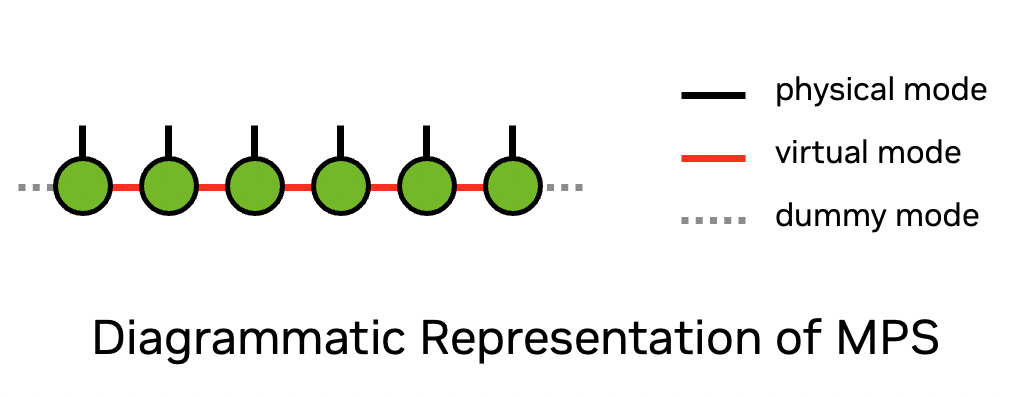

<mark>Note:</mark> In this sample, we've inserted a dummy mode of size 1 at the beginning and the end of the MPS to make it easier to generalize the handling of boundary conditions. This does not affect the outcome. 

The MPS representation of the circuit can be obtained by iteratively applying all gates to the initial MPS (typically $|\Psi_0\rangle = |00...00\rangle$). 
In the subsequent subsections, we'll go through these operations step by step followed by verification of correctness.

## II(a). Initialization

We begin by creating the initial MPS state $|\Psi_0\rangle = |00...00\rangle$. 

In [3]:
def get_initial_mps(num_qubits, dtype='complex128'):
    """
    Generate the MPS with an initial state of |00...00> 
    """
    state_tensor = cp.asarray([1, 0], dtype=dtype).reshape(1,2,1)
    mps_tensors = [state_tensor] * num_qubits
    return mps_tensors

dtype = 'complex128' # we will use double precision throughout this notebook
mps_tensors = get_initial_mps(num_qubits, dtype=dtype)

## II(b). Apply Gates to the MPS

Given an initial MPS state, we can begin applying all the gates in the quantum circuit to form the final MPS. 
The diagram below describes the application of single-qubit and two-qubit gates to an MPS. 

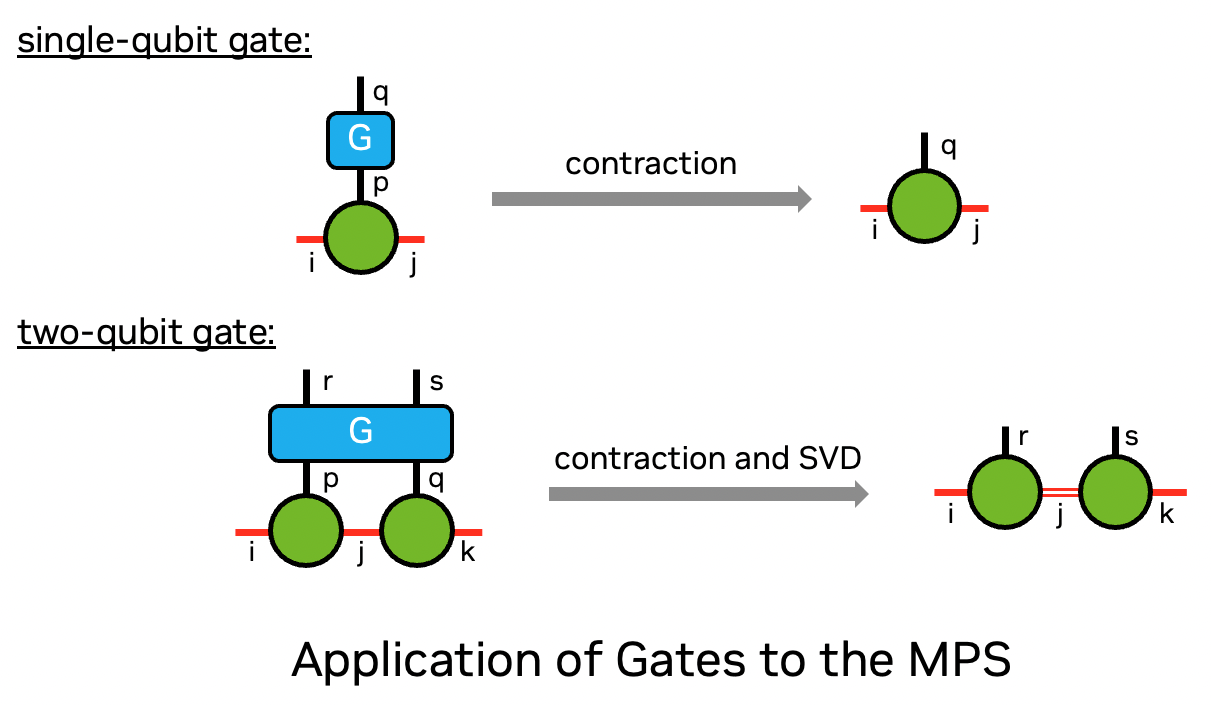

Specifically, application of a single-qubit gate amounts to a contraction problem dispatched to `cuquantum.contract`, while the application of a two-qubit gate maps to a contract-and-decompose task handled by `cuquantum.cutensornet.experimental.contract_decompose`.

<mark>Note:</mark> In the case of a two-qubit gate acting on non-adjacent qubits, an iterative swap step is required to first make the two qubits adjacent. 
There are multiple ways to achieve this goal. The diagram below describes two typical algorithms to swap the qubit indices of adjacent sites. 
Before the application of the gate, adjacent sites are swapped iteratively until the two involved sites are made adjacent. 
After the gate operand is applied, a reverse swap sweep is also needed to revert back to the original MPS site ordering.

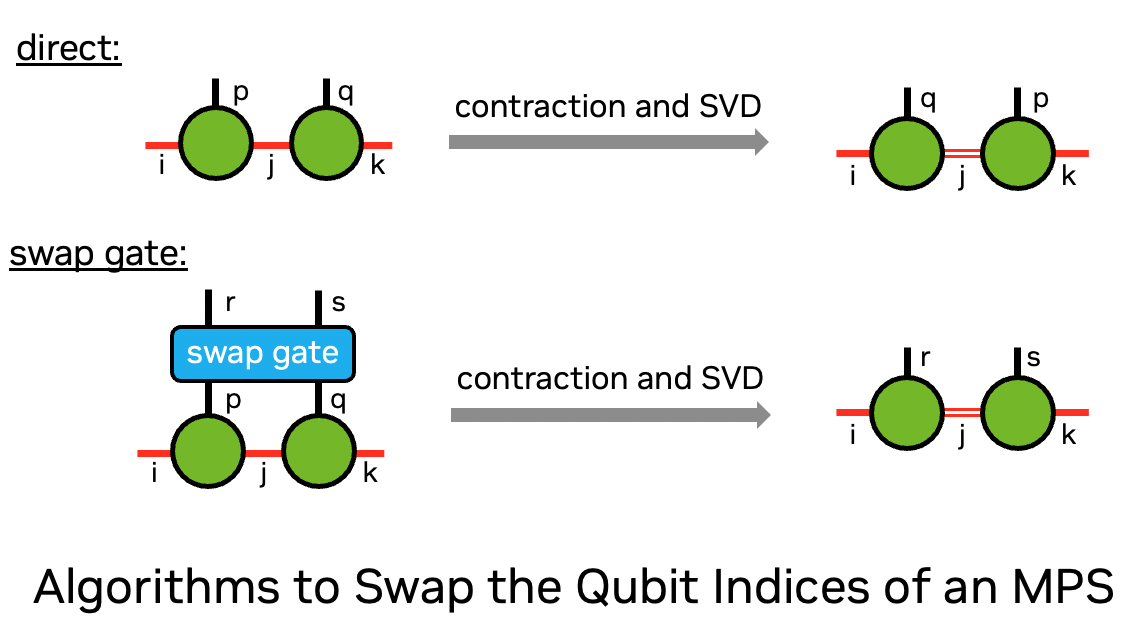

Although we will not encounter non-adjacent two-qubit gates in this example circuit, our `apply_gate` routine below supports the first swap algorithm in the diagram.

In [4]:
def mps_site_right_swap(
    mps_tensors, 
    i, 
    algorithm=None, 
    options=None
):
    """
    Perform the swap operation between the ith and i+1th MPS tensors.
    """
    # contraction followed by QR decomposition
    a, _, b = contract_decompose('ipj,jqk->iqj,jpk', *mps_tensors[i:i+2], algorithm=algorithm, options=options)
    mps_tensors[i:i+2] = (a, b)
    return mps_tensors

def apply_gate(
    mps_tensors, 
    gate, 
    qubits, 
    algorithm=None, 
    options=None
):
    """
    Apply the gate operand to the MPS tensors in-place.
    
    Args:
        mps_tensors: A list of rank-3 ndarray-like tensor objects. 
            The indices of the ith tensor are expected to be the bonding index to the i-1 tensor, 
            the physical mode, and then the bonding index to the i+1th tensor.
        gate: A ndarray-like tensor object representing the gate operand. 
            The modes of the gate is expected to be output qubits followed by input qubits, e.g, 
            ``A, B, a, b`` where ``a, b`` denotes the inputs and ``A, B`` denotes the outputs. 
        qubits: A sequence of integers denoting the qubits that the gate is applied onto.
        algorithm: The contract and decompose algorithm to use for gate application. 
            Can be either a `dict` or a `ContractDecomposeAlgorithm`.
        options: Specify the contract and decompose options. 
    
    Returns:
        The updated MPS tensors.
    """
    
    n_qubits = len(qubits)
    if n_qubits == 1:
        # single-qubit gate
        i = qubits[0]
        mps_tensors[i] = contract('ipj,qp->iqj', mps_tensors[i], gate, options=options) # in-place update
    elif n_qubits == 2:
        # two-qubit gate
        i, j = qubits
        if i > j:
            # swap qubits order
            return apply_gate(mps_tensors, gate.transpose(1,0,3,2), (j, i), algorithm=algorithm, options=options)
        elif i+1 == j:
            # two adjacent qubits
            a, _, b = contract_decompose('ipj,jqk,rspq->irj,jsk', *mps_tensors[i:i+2], gate, algorithm=algorithm, options=options)
            mps_tensors[i:i+2] = (a, b) # in-place update
        else:
            # non-adjacent two-qubit gate
            # step 1: swap i with i+1
            mps_site_right_swap(mps_tensors, i, algorithm=algorithm, options=options)
            # step 2: apply gate to (i+1, j) pair. This amounts to a recursive swap until the two qubits are adjacent
            apply_gate(mps_tensors, gate, (i+1, j), algorithm=algorithm, options=options) 
            # step 3: swap back i and i+1
            mps_site_right_swap(mps_tensors, i, algorithm=algorithm, options=options)
    else:
        raise NotImplementedError("Only one- and two-qubit gates supported")
    return mps_tensors


# We leverage ``cuquantum.CircuitToEinsum`` to obtain the gate operands.
myconverter = CircuitToEinsum(circuit, dtype=dtype, backend=cp)
gates = myconverter.gates
gate_map = dict(zip(myconverter.qubits, range(num_qubits)))

# We construct an exact MPS with algorithm below. 
# For two-qubit gates, an SVD is performed with singular values partitioned onto the two MPS sites equally.
# We also set a cutoff value of 1e-12 to filter out computational noise.
exact_gate_algorithm = {'qr_method': False, 
                        'svd_method':{'partition': 'UV', 'abs_cutoff':1e-12}}

# Constructing the final MPS
for (gate, qubits) in gates:
    # mapping from qubits to qubit indices
    qubits = [gate_map[q] for q in qubits]
    # apply the gate in-place
    apply_gate(mps_tensors, gate, qubits, algorithm=exact_gate_algorithm, options=options)

print("Final MPS is constructed with the following shapes")
for i, o in enumerate(mps_tensors):
    print(f"site {i}, shape: {o.shape}")

Final MPS is constructed with the following shapes
site 0, shape: (1, 2, 2)
site 1, shape: (2, 2, 4)
site 2, shape: (4, 2, 8)
site 3, shape: (8, 2, 16)
site 4, shape: (16, 2, 8)
site 5, shape: (8, 2, 4)
site 6, shape: (4, 2, 2)
site 7, shape: (2, 2, 1)


## II(c). Correctness Verification

We can now verify the correctness of the final MPS with the following tests:
- Determining whether the MPS is normalized to 1.0.
- Establishing that the state represented by the MPS is equivalent to the state vector.

Note that the first test holds in this example as we're constructing the exact MPS representation. In the case of approximate MPS, manual normalization is needed.

To make our verification easier, we provide an `MPSContractionHelper` class to help compute various target quantities for MPS for reference.
These quantities are all computed by exact contraction of the corresponding MPS tensor network.  


In [5]:
class MPSContractionHelper:
    """
    A helper class to compute various quantities for a given MPS using exact contraction.
    
    Interleaved format is used to construct the input args for `cuquantum.contract`. 
    A concrete example on how the modes are populated for a 7-site MPS is provided below:
    
          0     2     4     6     8    10     12    14        
    bra -----A-----B-----C-----D-----E-----F-----G-----
             |     |     |     |     |     |     |     
            1|    3|    5|    7|    9|   11|   13|     
             |     |     |     |     |     |     |     
    ket -----a-----b-----c-----d-----e-----f-----g-----
          15    16    17    18    19    20    21    22
    
    
    The follwing compute quantities are supported:
    
        - the norm of the MPS.
        - the equivalent state vector from the MPS.
        - the expectation value for a given operator.
        - the equivalent state vector after multiplying an MPO to an MPS.
    
    Note that for the nth MPS tensor (rank-3), the modes of the tensor are expected to be `(i,p,j)` 
    where i denotes the bonding mode with the (n-1)th tensor, p denotes the physical mode for the qubit and 
    j denotes the bonding mode with the (n+1)th tensor.
    
    Args:
        num_qubits: The number of qubits for the MPS.
    """
    
    def __init__(self, num_qubits):
        self.num_qubits = num_qubits
        self.path_cache = dict()
        self.bra_modes = [(2*i, 2*i+1, 2*i+2) for i in range(num_qubits)]
        offset = 2*num_qubits+1
        self.ket_modes = [(i+offset, 2*i+1, i+1+offset) for i in range(num_qubits)]
    
    def contract_norm(self, mps_tensors, options=None):
        """
        Contract the corresponding tensor network to form the norm of the MPS.

        Args:
            mps_tensors: A list of rank-3 ndarray-like tensor objects. 
                The indices of the ith tensor are expected to be bonding index to the i-1 tensor, 
                the physical mode, and then the bonding index to the i+1th tensor.
            options: Specify the contraction options. 

        Returns:
            The norm of the MPS.
        """
        interleaved_inputs = []
        for i, o in enumerate(mps_tensors):
            interleaved_inputs.extend([o, self.bra_modes[i], o.conj(), self.ket_modes[i]])
        interleaved_inputs.append([]) # output
        return self._contract('norm', interleaved_inputs, options=options).real

    def contract_state_vector(self, mps_tensors, options=None):
        """
        Contract the corresponding tensor network to form the state vector representation of the MPS.

        Args:
            mps_tensors: A list of rank-3 ndarray-like tensor objects. 
                The indices of the ith tensor are expected to be bonding index to the i-1 tensor, 
                the physical mode, and then the bonding index to the i+1th tensor.
            options: Specify the contraction options. 

        Returns:
            An ndarray-like object as the state vector.
        """
        interleaved_inputs = []
        for i, o in enumerate(mps_tensors):
            interleaved_inputs.extend([o, self.bra_modes[i]])
        output_modes = tuple([bra_modes[1] for bra_modes in self.bra_modes])
        interleaved_inputs.append(output_modes) # output
        return self._contract('sv', interleaved_inputs, options=options)
    
    def contract_expectation(self, mps_tensors, operator, qubits, normalize=False, options=None):
        """
        Contract the corresponding tensor network to form the state vector representation of the MPS.

        Args:
            mps_tensors: A list of rank-3 ndarray-like tensor objects. 
                The indices of the ith tensor are expected to be bonding index to the i-1 tensor, 
                the physical mode, and then the bonding index to the i+1th tensor.
            operator: A ndarray-like tensor object. 
                The modes of the operator are expected to be output qubits followed by input qubits, e.g, 
                ``A, B, a, b`` where `a, b` denotes the inputs and `A, B'` denotes the outputs. 
            qubits: A sequence of integers specifying the qubits that the operator is acting on. 
            normalize: Whether to scale the expectation value by the normalization factor.
            options: Specify the contraction options. 

        Returns:
            An ndarray-like object as the state vector.
        """
        
        interleaved_inputs = []
        extra_mode = 3 * self.num_qubits + 2
        operator_modes = [None] * len(qubits) + [self.bra_modes[q][1] for q in qubits]
        qubits = list(qubits)
        for i, o in enumerate(mps_tensors):
            interleaved_inputs.extend([o, self.bra_modes[i]])
            k_modes = self.ket_modes[i]
            if i in qubits:
                k_modes = (k_modes[0], extra_mode, k_modes[2])
                q = qubits.index(i)
                operator_modes[q] = extra_mode # output modes
                extra_mode += 1
            interleaved_inputs.extend([o.conj(), k_modes])
        interleaved_inputs.extend([operator, tuple(operator_modes)])
        interleaved_inputs.append([]) # output
        if normalize:
            norm = self.contract_norm(mps_tensors, options=options)
        else:
            norm = 1
        return self._contract(f'exp{qubits}', interleaved_inputs, options=options) / norm
    
    def contract_mps_mpo_to_state_vector(self, mps_tensors, mpo_tensors, options=None):
        """
        Contract the corresponding tensor network to form the output state vector from applying the MPO to the MPS.

        Args:
            mps_tensors: A list of rank-3 ndarray-like tensor objects. 
                The indices of the ith tensor are expected to be the bonding index to the i-1 tensor, 
                the physical mode, and then the bonding index to the i+1th tensor.
            mpo_tensors: A list of rank-4 ndarray-like tensor objects.
                The indics of the ith tensor are expected to be the bonding index to the i-1 tensor, 
                the output physical mode, the bonding index to the i+1th tensor and then the inputput physical mode.
            options: Specify the contraction options. 

        Returns:
            An ndarray-like object as the output state vector.
        """
        interleaved_inputs = []
        for i, o in enumerate(mps_tensors):
            interleaved_inputs.extend([o, self.bra_modes[i]])
        output_modes = []
        offset = 2 * self.num_qubits + 1
        for i, o in enumerate(mpo_tensors):
            mpo_modes = (2*i+offset, 2*i+offset+1, 2*i+offset+2, 2*i+1)
            output_modes.append(2*i+offset+1)
            interleaved_inputs.extend([o, mpo_modes])
        interleaved_inputs.append(output_modes)
        return self._contract('mps_mpo', interleaved_inputs, options=options)
    
    def _contract(self, key, interleaved_inputs, options=None):
        """
        Perform the contraction task given interleaved inputs. Path will be cached.
        """
        if key not in self.path_cache:
            self.path_cache[key] = contract_path(*interleaved_inputs, options=options)[0]
        path = self.path_cache[key]
        return contract(*interleaved_inputs, options=options, optimize={'path':path})

mps_helper = MPSContractionHelper(num_qubits)

# compute the norm of the MPS.
norm = mps_helper.contract_norm(mps_tensors, options=options)
print(f"The norm of the MPS: {norm:0.3e}")

# comparision with state vector
# state vector constructed from the MPS
sv_mps = mps_helper.contract_state_vector(mps_tensors, options=options)
# reference from CircuitToEinsum
subscripts, operands = myconverter.state_vector()
sv_reference = contract(subscripts, *operands, options=options)

print(f"State vector difference: {abs(sv_mps-sv_reference).max():0.3e}")
assert cp.allclose(sv_mps, sv_reference)

The norm of the MPS: 1.000e+00
State vector difference: 2.346e-15


# III. MPS Canonicalization

One nice property of the MPS is that its canonical form allows for easy computation of expectation values or reduced density matrices. 

For instance, if one were to compute the expectation value of a two-qubit operator, two approaches shown below can be adopted:
- Contraction of the original $\langle\Psi|\hat{O}|\Psi\rangle$ tensor network where $|\Psi\rangle$ is now an MPS.
- Contraction of a sub-network after proper canonicalization.

The example below is based on a two-body operator acting on the 3rd and 4th qubits

## III(a). Expectation Value from Full MPS computation.

Here we first contract the full MPS graph shown below to compute the expectation value.

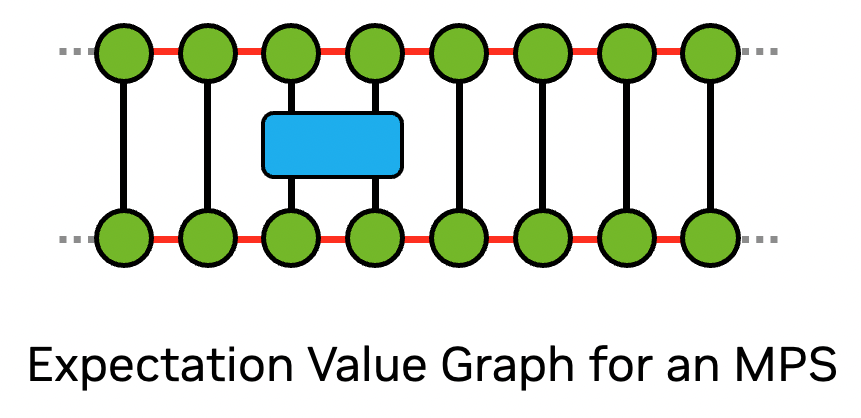


In [6]:
target_qubits = (2, 3)
# create a random two-body operator
operator = cp.random.random([2,2,2,2]) + 1.j * cp.random.random([2,2,2,2])

# reference from contraction of the full <MPS|OP|MPS> network
# since the MPS is already normalized under exact representation, we don't need to normalize it here.
expec_mps_reference = mps_helper.contract_expectation(mps_tensors, operator, target_qubits, options=options, normalize=False)

# reference from state vector
expec_sv_reference = contract('ijklmnop,ijKLmnop,KLkl->', sv_reference, sv_reference.conj(), operator, options=options)

print(f"Expectation value at qubits {target_qubits}")
print(f"<MPS|OP|MPS>: {expec_mps_reference}")
print(f"<SV|OP|SV>: {expec_sv_reference}")

is_expec_equal = cp.allclose(expec_mps_reference, expec_sv_reference)
print(f"<MPS|OP|MPS> equal to <SV|OP|SV>? : {is_expec_equal}")
assert is_expec_equal

Expectation value at qubits (2, 3)
<MPS|OP|MPS>: (0.34424195503028765+0.3835552948014175j)
<SV|OP|SV>: (0.3442419550302868+0.3835552948014166j)
<MPS|OP|MPS> equal to <SV|OP|SV>? : True


## III(b). Expectation Value from Canonical MPS

In this section we aim to compute the same expectation value using canonicalization techniques for MPS. 
Canonicalization of MPS can be visualized as illustrated in the diagrams shown below. 
We can start from either one side of the MPS to perform a sequence of QR decompositions and contractions such that all MPS tensors on one site become unitary (denoted as gray squares in the figure). 
We can perform the sweep from both sides in order to shift the canonicalization center to be around the central qubit sites, where the operator is acting on.

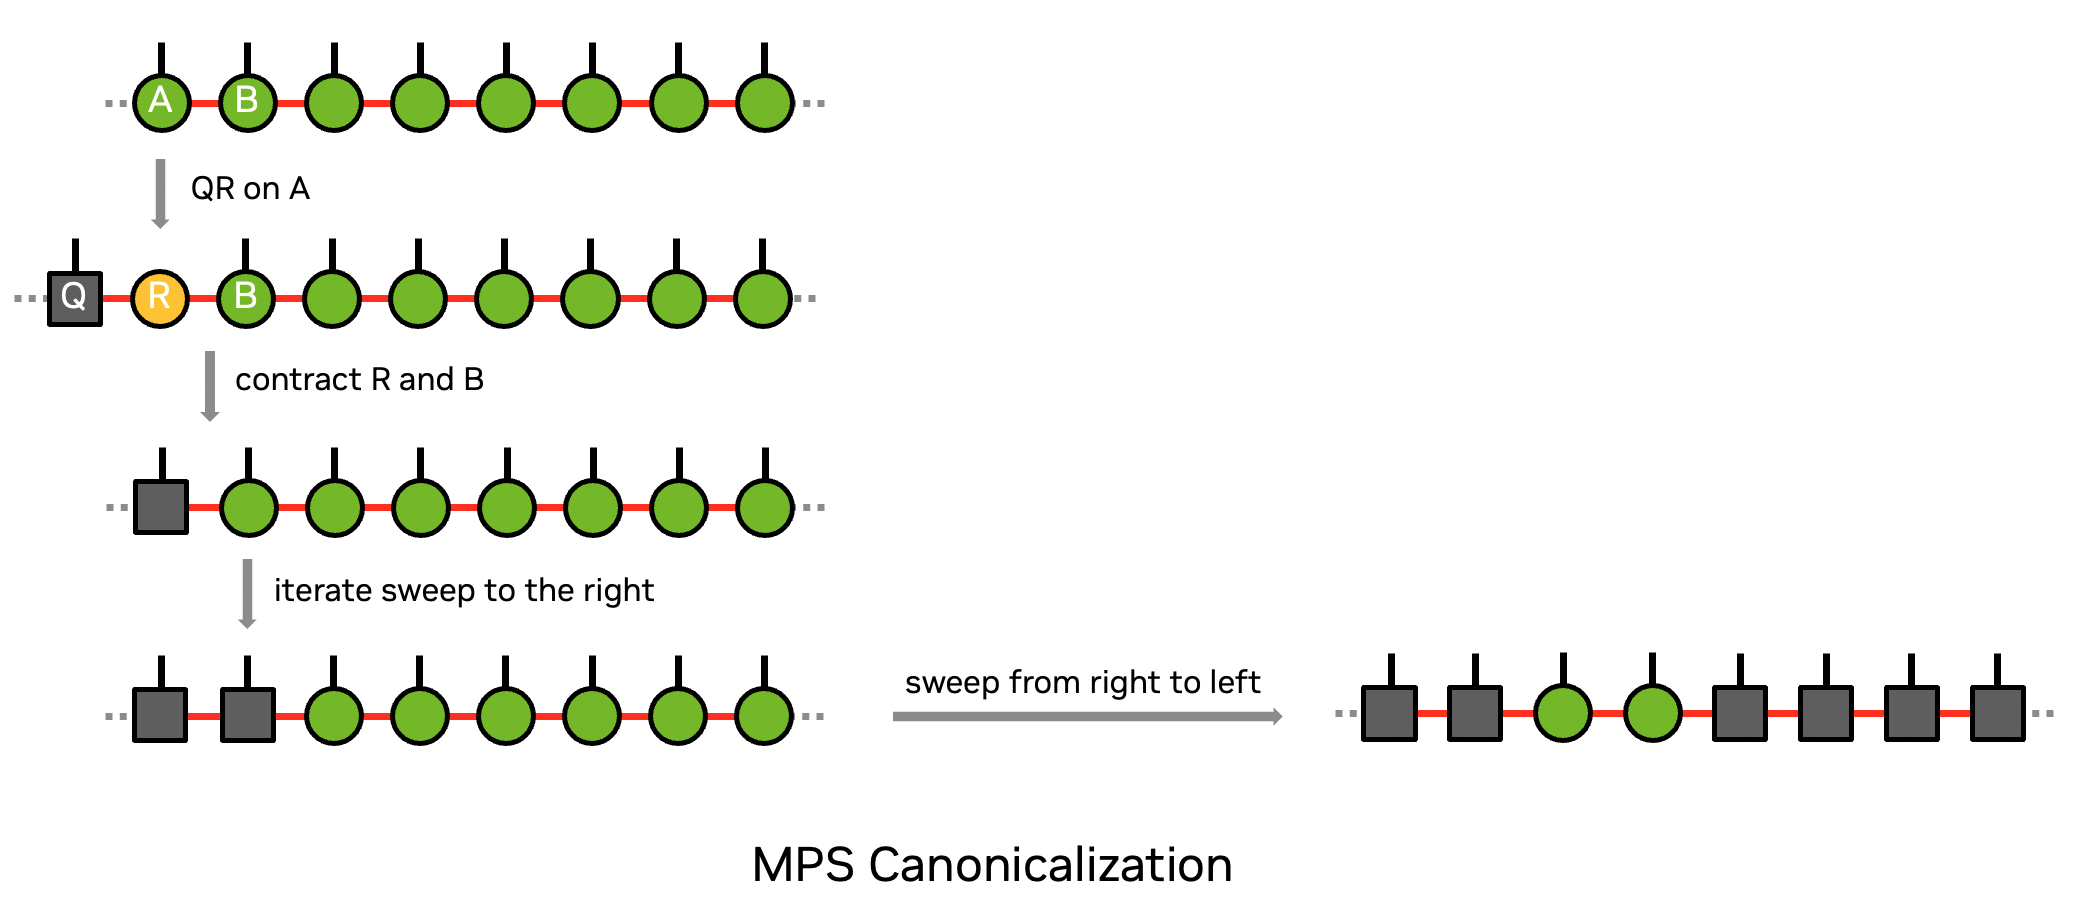

Once the MPS is canonicalized around the target qubits, the expectation value problem can be reduced to a contraction task on a sub-graph. 
The process can be illustrated by the figure below where the reduction of the graph comes from the fact that contraction of the unitary MPS tensors (denoted by gray squares) with their Hermitian conjugates yields identity matrices.

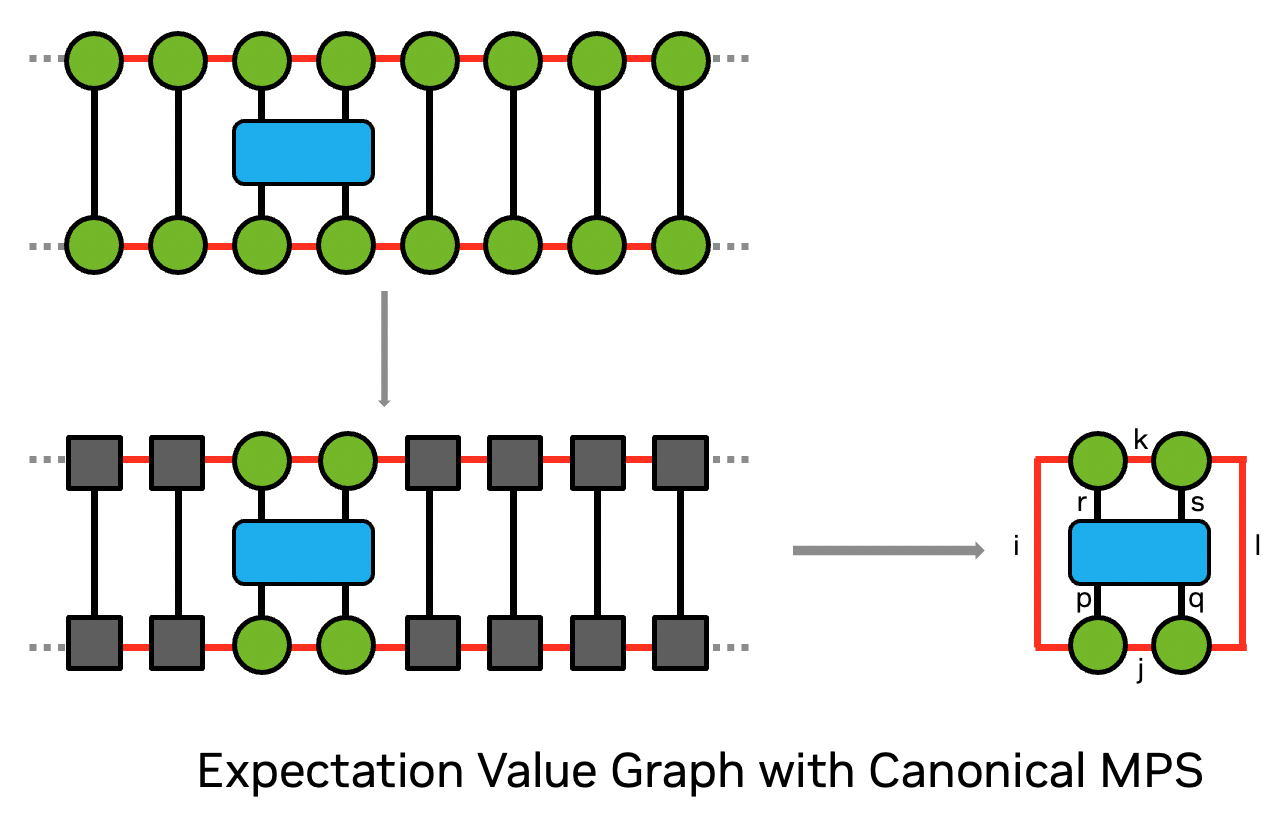

In [7]:
def canonicalize_mps_tensors(a, b, absorb='right', options=None):
    """
    Perform canonicalization of two MPS tensors.
    """
    if absorb == 'right':
        a, r = tensor.decompose('ipj->ipx,xj', a, options=options) # QR on a
        b = contract('xj,jpk->xpk', r, b, options=options) # combine b with r
    elif absorb == 'left':
        b, r = tensor.decompose('jpk->xpk,jx', b, options=options) # QR on b
        a = contract('jx,ipj->ipx', r, a, options=options) # combine a with r 
    else:
        raise ValueError(f"absorb must be either left or right")
    return a, b

def right_canonicalize_mps(mps_tensors, start, end, options=None):
    """
    Perform a in-place canonicalization sweep of MPS from left to right.
    
    Args:
        mps_tensors: A list of rank-3 ndarray-like tensor objects. 
            The indices of the ith tensor is expected to be the bonding index to the i-1 tensor, 
            the physical mode and then the bonding index to the i+1th tensor.
        start: The first site for right canonicalization.
        end: The last site for right canonicalization.
        options: Specify the contract and decompose options. 
    """
    
    assert end > start
    num_sites = len(mps_tensors)
    for i in range(start, end):
        mps_tensors[i:i+2] = canonicalize_mps_tensors(*mps_tensors[i:i+2], absorb='right', options=options)
    return mps_tensors

def left_canonicalize_mps(mps_tensors, start, end, options=None):
    """
    Perform a in-place canonicalization sweep of MPS from right to left.
    
    Args:
        mps_tensors: A list of rank-3 ndarray-like tensor objects. 
            The indices of the ith tensor is expected to be the bonding index to the i-1 tensor, 
            the physical mode and then the bonding index to the i+1th tensor.
        start: The first site for left canonicalization.
        end: The last site for left canonicalization.
        options: Specify the contract and decompose options. 
    """
    assert start > end
    for i in range(start, end, -1):
        mps_tensors[i-1:i+1] = canonicalize_mps_tensors(*mps_tensors[i-1:i+1], absorb='left', options=options)
    return mps_tensors

# create a copy to avoid in-place modification
canonical_mps = mps_tensors.copy()

# right sweep of MPS canonicalization from the beginning to the 3rd site 
right_canonicalize_mps(canonical_mps, 0, target_qubits[0], options=options)
# left sweep of MPS canonicalization from the end to the 4th site 
left_canonicalize_mps(canonical_mps, num_qubits-1, target_qubits[1], options=options)


# compute the expectation value using the reduced graph
expec_mps_canonical = contract('ipj,jql,irk,ksl,rspq->', canonical_mps[target_qubits[0]], canonical_mps[target_qubits[1]], canonical_mps[target_qubits[0]].conj(), canonical_mps[target_qubits[1]].conj(), operator, options=options)
print(f"<canonical MPS|OP|canonical MPS> with reduced graph: {expec_mps_canonical}")
is_canonical_expec_equal = cp.allclose(expec_mps_canonical, expec_mps_reference)
print(f"reduced <canonical MPS|OP|canonical MPS> equal to <MPS|OP|MPS>?: {is_canonical_expec_equal}")
assert is_canonical_expec_equal

# For validation, we can also compute the expectation value (wrong) from the reduced graph with the original MPS
expec_mps_reduced = contract('ipj,jql,irk,ksl,rspq->', mps_tensors[target_qubits[0]], mps_tensors[target_qubits[1]], mps_tensors[target_qubits[0]].conj(), mps_tensors[target_qubits[1]].conj(), operator, options=options)
print(f"original <MPS|OP|MPS> with reduced graph: {expec_mps_reduced}")

is_reduced_expec_equal = cp.allclose(expec_mps_canonical, expec_mps_reduced)
print(f"Equal to reference?: {is_reduced_expec_equal} (False expected)")
assert not is_reduced_expec_equal

<canonical MPS|OP|canonical MPS> with reduced graph: (0.34424195503028765+0.38355529480141753j)
reduced <canonical MPS|OP|canonical MPS> equal to <MPS|OP|MPS>?: True
original <MPS|OP|MPS> with reduced graph: (1.106354971695589+1.0291661220130153j)
Equal to reference?: False (False expected)


# IV. MPS MPO Multiplication

In this section we'll describe how to perform MPS and MPO multiplications with `cuquantum-python`. 
The problem can be visualized using the diagram below:

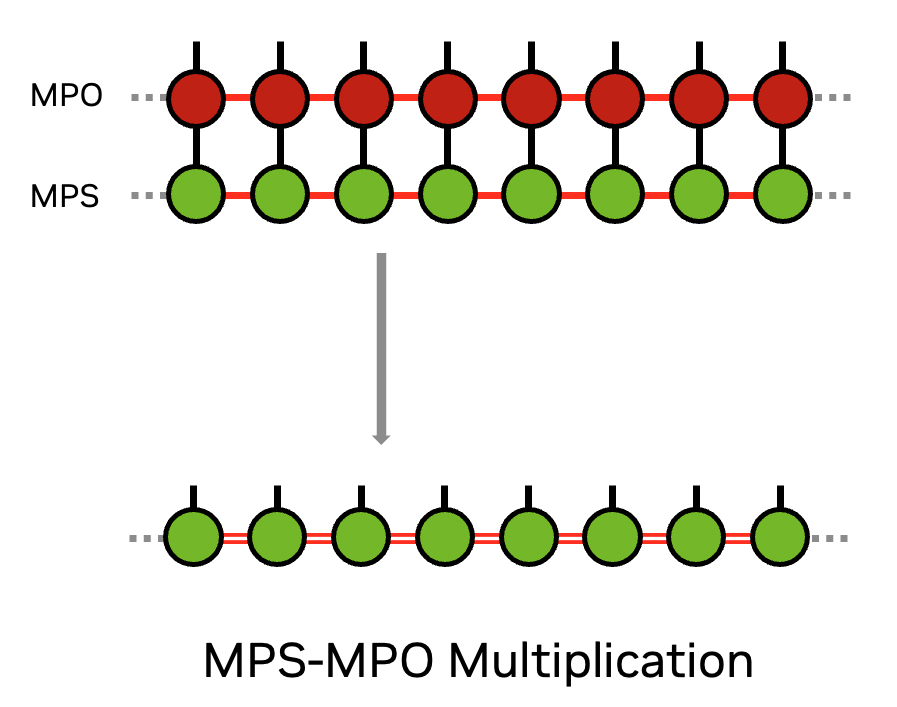

We will describe two types of algorithms to perform the multiplication. Specifically, the following topics will be covered:

- Initializing a random MPO.
- Contracting MPS and MPO exactly using a direct algorithm and verifying its correctness.
- Contracting MPS and MPO exactly using an algorithm based on density matrix and verifying its correctness.
- Evaluating the accuracy of approximate MPS MPO multiplication using the two algorithms above.

## IV(a). Generate a Random MPO

Here we first create a random MPO for subsequent operations. Like we did with MPS, we will insert a dummpy index in the first and the last MPO tensor.

In [8]:
def get_random_mpo(num_qubits, D=4):
    """
    Generate a random MPO with specified bond dimension. 
    
    Note the indices of ith MPO tensor are `(a, P, b, p)` where a, b denote the bonding indices to the 
    (i-1)th and (i+1)th tensor while P and p denote the output and input physical modes, respectively.
    """
    mpo_tensors = []
    for i in range(num_qubits):
        left_bond = 1 if i==0 else D
        right_bond = 1 if i==num_qubits-1 else D
        shape = (left_bond, 2, right_bond, 2)
        o = cp.random.random(shape) + 1.j * cp.random.random(shape)
        # normalize
        o /= cp.linalg.norm(o)
        mpo_tensors.append(o)
    return mpo_tensors

mpo_tensors = get_random_mpo(num_qubits, D=4)

## IV(b). Exact MPS MPO Multiplication with Direct Algorithm

There are various algorithms to perform MPS MPO multiplication. In the diagram below we present one simple algorithm based on direct contraction and SVD. 

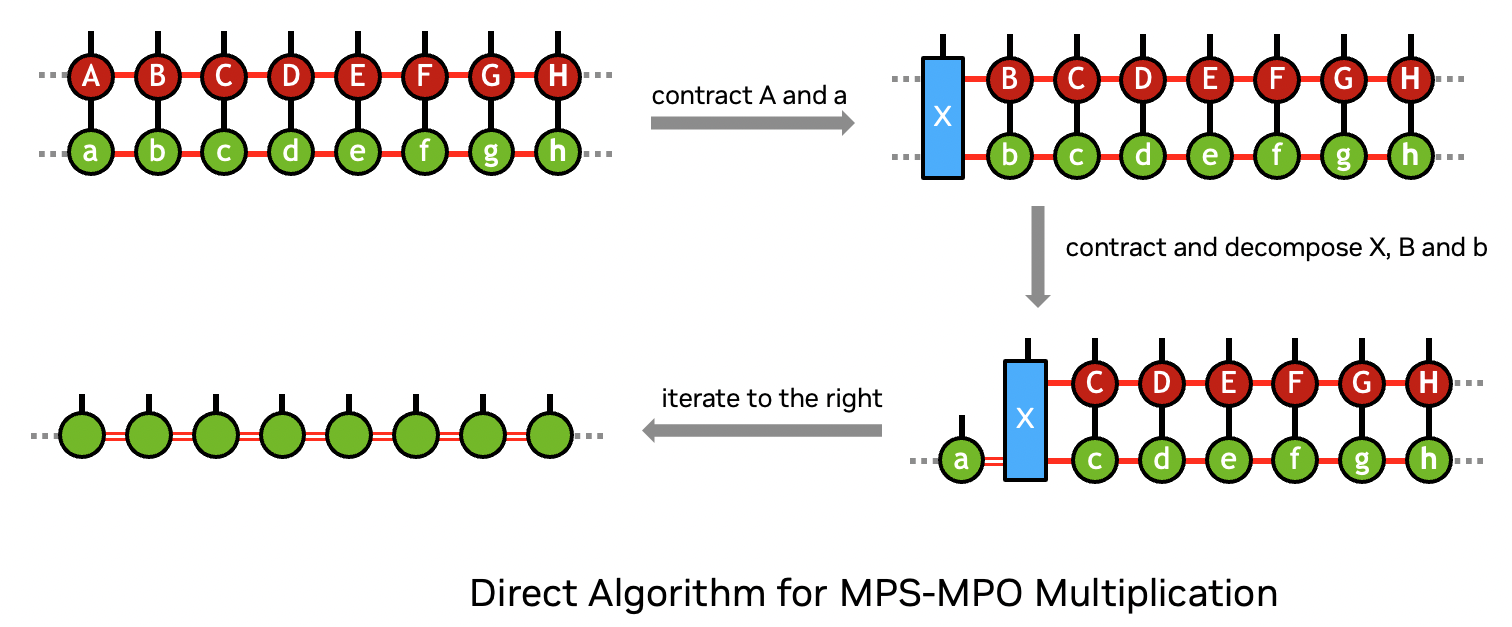

Note that during SVD, we can partition the singular values to the right tensor such that the resulting MPS we obtain is in the right orthogonal gauge.

We perform the following checks to verify the correctness of our algorithm:
- Comparing the states presented by the output MPS against direct contraction.
- Computing the expectation value of a one-body operator acting on the canonicalization center using a reduced graph. 


In [9]:
def multiply_mps_mpo_direct(mps_tensors, mpo_tensors, svd_method, canonical_center="right", options=None):
    """
    Perform MPS MPO multiplication using the direct algorithm shown above.
    
    Args:
        mps_tensors: A list of rank-3 ndarray-like tensor objects. 
            The indices of the ith tensor is expected to be the bonding index to the i-1 tensor, 
            the physical mode and then the bonding index to the i+1th tensor.
        mpo_tensors: A list of rank-4 ndarray-like tensor objects.
            The indics of the ith tensor are expected to be the bonding index to the i-1 tensor, 
            the output physical mode, the bonding index to the i+1th tensor and then the inputput physical mode.
        svd_method: A tensor.SVDMethod object specifying the options for the SVD truncation. 
            For the direct algorithm, the `partition` attribute must be set to `V` for proper canonicalization.
        canonical_center: A string specifying the final canonicalization center, can be either `left` or `right`.
        options: Specify the contract and decompose options. 
    """
    if svd_method.partition != 'V':
        raise ValueError(f"The direct algorithm expects SVDMethod.partition to be V, found {svd_method.partition}")
    num_qubits = len(mps_tensors)
    algorithm = {'qr_method': False,
                 'svd_method': svd_method}
    output_mps = [None,] * num_qubits
    X = None
    if canonical_center == 'right':
        for i in range(num_qubits):
            if X is None:
                X = contract('ipj,kmlp->imlj', mps_tensors[i], mpo_tensors[i], options=options)
            else:
                mps, _, X = contract_decompose('imlj,jqr,lnsq->imx,xnsr', X, mps_tensors[i], mpo_tensors[i], algorithm=algorithm, options=options)
                output_mps[i-1] = mps
        output_mps[-1] = X.reshape(-1,2,1)
    elif canonical_center == 'left':
        for i in range(num_qubits-1, -1, -1):
            if X is None:
                X = contract('ipj,kmlp->ikmj', mps_tensors[i], mpo_tensors[i], options=options)
            else:
                mps, _, X = contract_decompose('ikmj,lqi,npkq->xmj,lnpx', X, mps_tensors[i], mpo_tensors[i], algorithm=algorithm, options=options)
                output_mps[i+1] = mps
        output_mps[0] = X.reshape(1,2,-1)
    else:
        raise ValueError("canonical_center must be either left or right")
    return output_mps

svd_method = tensor.SVDMethod(partition='V', rel_cutoff=1e-10)
canonical_center = 'right' # target canonicalization center, can be 'left' as well

# multiply MPS with MPO using direct algorithm
mps_mpo_direct = multiply_mps_mpo_direct(mps_tensors, mpo_tensors, svd_method, canonical_center=canonical_center, options=options)

print("After exact MPS-MPO multiplication using direct algorithm")
for i, o in enumerate(mps_mpo_direct):
    print(f"site {i}, shape: {o.shape}")

# compute the state vector after MPS-MPO multiplication
mps_mpo_sv_direct = mps_helper.contract_state_vector(mps_mpo_direct, options=options)

# reference state vector from full network contraction
mps_mpo_sv_ref = mps_helper.contract_mps_mpo_to_state_vector(mps_tensors, mpo_tensors, options=options)
print(f"Max absolute difference compared with reference state vector: {abs(mps_mpo_sv_direct-mps_mpo_sv_ref).max():0.3e}")
assert cp.allclose(mps_mpo_sv_direct, mps_mpo_sv_ref)

# compute the expectation value of a one body operator on the canonicalization center
one_body_operator = cp.random.random([2,2]) + 1j* cp.random.random([2,2])
operator_site = {'right': num_qubits-1,
                 'left': 0}[canonical_center]

# reference expectation value from contracting the full <MPS|O|MPS> network
expec_direct_full = mps_helper.contract_expectation(mps_mpo_direct, one_body_operator, (operator_site, ), normalize=True, options=options)
# expectation value from the reduced graph on the canonical center
expec_direct_reduced = contract('ipj,iPj,Pp->', mps_mpo_direct[operator_site], mps_mpo_direct[operator_site].conj(), one_body_operator, options=options)
expec_direct_reduced /= cp.linalg.norm(mps_mpo_direct[operator_site]) ** 2

is_direct_canonical = cp.allclose(expec_direct_full, expec_direct_reduced)
print(f"Is the canonicalization center moved to the {canonical_center}?: {is_direct_canonical}")
assert is_direct_canonical


After exact MPS-MPO multiplication using direct algorithm
site 0, shape: (1, 2, 2)
site 1, shape: (2, 2, 4)
site 2, shape: (4, 2, 8)
site 3, shape: (8, 2, 16)
site 4, shape: (16, 2, 32)
site 5, shape: (32, 2, 16)
site 6, shape: (16, 2, 2)
site 7, shape: (2, 2, 1)
Max absolute difference compared with reference state vector: 6.606e-18
Is the canonicalization center moved to the right?: True


## IV(c). Exact MPS MPO Multiplication with Density Matrix Algorithm

The density matrix algorithm for MPS MPO multiplication is based on iterative truncation on the density matrix. 
For detailed introduction on the algorithm, user may refer to this [tutorial page](https://tensornetwork.org/mps/algorithms/denmat_mpo_mps/) or this [paper](https://iopscience.iop.org/article/10.1088/1742-5468/2007/10/P10014). 
Since the truncation is performed on the density matrix, approximation using this algorithm is generally expected to be more accurate than the direct approach. 

In this subsection, we provide a reference implementation in function `multiply_mps_mpo_density_matrix` and verify its correctness using the same checks as we did with the direct algorithm.

In [10]:
def multiply_mps_mpo_density_matrix(mps_tensors, mpo_tensors, svd_method, canonical_center="right", options=None):
    """
    Perform MPS MPO multiplication using the density matrix algorithm.
    
    Args:
        mps_tensors: A list of rank-3 ndarray-like tensor objects. 
            The indices of the ith tensor is expected to be the bonding index to the i-1 tensor, 
            the physical mode and then the bonding index to the i+1th tensor.
        mpo_tensors: A list of rank-4 ndarray-like tensor objects.
            The indics of the ith tensor are expected to be the bonding index to the i-1 tensor, 
            the output physical mode, the bonding index to the i+1th tensor and then the inputput physical mode.
        svd_method: A tensor.SVDMethod object specifying the options for the SVD truncation. 
            For the density matrix algorithm, the `partition` attribute must be set to `None` for proper canonicalization.
        canonical_center: A string specifying the final canonicalization center, can be either `left` or `right`.
        options: Specify the contract and decompose options. 
    """
    if svd_method.partition is not None:
        raise ValueError(f"The density matrix algorithm expects SVDMethod.partition to be None, found {svd_method.partition}")
    if len(mps_tensors) != len(mpo_tensors):
        raise ValueError(f"The number of MPS tensor {len(mps_tensors)} does not match that of MPO tensors {len(mpo_tensors)}")
        
    n = len(mps_tensors)
    algo = {'qr_method': False, 'svd_method': svd_method}
    envs = dict()
    mps_mpo_tensors = []
    for i in range(n):
        # multiply the MPS tensor with the MPO tensor at the same site
        mps_mpo_tensors.append(contract('ijk,lnmj->ilnmk', mps_tensors[i], mpo_tensors[i], options=options))
    new_mps_tensors = [None] * n
    if canonical_center == 'left':
        # construct the environment tensors with an inverse sweep from left to right
        for i in range(n-1):
            if i==0:
                envs[i] = contract('ilnmk,ILnMK->kmKM', mps_mpo_tensors[i], mps_mpo_tensors[i].conj(), options=options)
            else:
                # contract the MPS-MPO with its left env to construct the next env 
                envs[i] = contract('ilIL,ilnmk,ILnMK->kmKM', envs[i-1], mps_mpo_tensors[i], mps_mpo_tensors[i].conj(), options=options)
        R_tensor = None
        for i in range(n-1, 0, -1):
            if R_tensor is None:
                # contract and decompose ---MPS_MPO---left_env---MPS_MPO^*--- to compute the new MPS tensor at last site
                u, s, v = contract_decompose('ilIL,ilnmk,ILNMK->xnk,xNK', envs[i-1], mps_mpo_tensors[i], mps_mpo_tensors[i].conj(), algorithm=algo, options=options)
                R_tensor = contract('ilnmk,xnr->ilx', mps_mpo_tensors[i], v, options=options)
            else:
                # contract and decompose R_i---MPS_MPO_i---left_env_i---MPS_MPO_i^*---R_i^* to compute the unitary u as the new compressed MPS tensor
                u, s, v = contract_decompose('ilIL,ilnmk,ILNMK,kmx,KMX->znx,zNX', envs[i-1], mps_mpo_tensors[i], mps_mpo_tensors[i].conj(), R_tensor, R_tensor.conj(), algorithm=algo, options=options)
                # form R_i+1 by contracting MPS_MPO_i, V_i and R_i
                R_tensor = contract('ilnmk,znx,kmx->ilz', mps_mpo_tensors[i], v, R_tensor, options=options)
            new_mps_tensors[i] = u
        # contract MPS_MPO_0 with R_0 as the first MPS tensor
        new_mps_tensors[0] = contract('ilnmk,kmx->inx', mps_mpo_tensors[0], R_tensor, options=options)
    elif canonical_center == 'right':
        # construct the environment tensors with an inverse sweep from right to left
        for i in range(n-1, 0, -1):
            if i == n-1:
                envs[i] = contract('ilnmk,ILnMK->ilIL', mps_mpo_tensors[i], mps_mpo_tensors[i].conj(), options=options)
            else:
                # contract the MPS-MPO with its right env to construct the next env 
                envs[i] = contract('kmKM,ilnmk,ILnMK->ilIL', envs[i+1], mps_mpo_tensors[i], mps_mpo_tensors[i].conj(), options=options)
        L_tensor = None
        for i in range(n-1):
            if L_tensor is None:
                # contract and decompose ---MPS_MPO---right_env---MPS_MPO^*--- to compute the new MPS tensor at last site
                u, s, v = contract_decompose('kmKM,ilnmk,ILNMK->inx,INx', envs[i+1], mps_mpo_tensors[i], mps_mpo_tensors[i].conj(), algorithm=algo, options=options)
                L_tensor = contract('ilnmk,rnx->xmk', mps_mpo_tensors[i], v, options=options)
            else:
                # contract and decompose L_i---MPS_MPO_i---right_env_i---MPS_MPO_i^*---L_i^* to compute the unitary u as the new compressed MPS tensor
                u, s, v = contract_decompose('kmKM,ilnmk,ILNMK,xli,XLI->xnz,XNz', envs[i+1], mps_mpo_tensors[i], mps_mpo_tensors[i].conj(), L_tensor, L_tensor.conj(), algorithm=algo, options=options)
                L_tensor = contract('ilnmk,xnz,xli->zmk', mps_mpo_tensors[i], v, L_tensor, options=options)
            new_mps_tensors[i] = u
        # contract the last MPS_MPO with L as the last MPS tensor
        new_mps_tensors[n-1] = contract('ilnmk,xli->xnk', mps_mpo_tensors[n-1], L_tensor, options=options)
    else:
        raise ValueError("sweep direction must be either left or right")
                
    return new_mps_tensors


svd_method = tensor.SVDMethod(rel_cutoff=1e-12)

# multiply MPS with MPO using density matrix algorithm
mps_mpo_dm = multiply_mps_mpo_density_matrix(mps_tensors, mpo_tensors, svd_method, canonical_center=canonical_center, options=options)
print("After exact MPS-MPO multiplication using density matrix algorithm")
for i, o in enumerate(mps_mpo_dm):
    print(f"site {i}, shape: {o.shape}")

# compute the state vector after MPS-MPO multiplication
mps_mpo_sv_dm = mps_helper.contract_state_vector(mps_mpo_dm, options=options)
print(f"Max absolute difference compared with reference state vector: {abs(mps_mpo_sv_dm-mps_mpo_sv_ref).max():0.3e}")
assert cp.allclose(mps_mpo_sv_dm, mps_mpo_sv_ref)

# reference from contracting the full <MPS|O|MPS> network
expec_dm_full = mps_helper.contract_expectation(mps_mpo_dm, one_body_operator, (operator_site, ), normalize=True, options=options)
# expectation value from the reduced graph on the canonical center
expec_dm_reduced = contract('ipj,iPj,Pp->', mps_mpo_dm[operator_site], mps_mpo_dm[operator_site].conj(), one_body_operator, options=options)
expec_dm_reduced /= cp.linalg.norm(mps_mpo_dm[operator_site]) ** 2

is_dm_canonical = cp.allclose(expec_dm_full, expec_dm_reduced)
print(f"Is the canonicalization center moved to the {canonical_center}?: {is_dm_canonical}")
assert is_dm_canonical

After exact MPS-MPO multiplication using density matrix algorithm
site 0, shape: (1, 2, 2)
site 1, shape: (2, 2, 4)
site 2, shape: (4, 2, 8)
site 3, shape: (8, 2, 16)
site 4, shape: (16, 2, 8)
site 5, shape: (8, 2, 4)
site 6, shape: (4, 2, 2)
site 7, shape: (2, 2, 1)
Max absolute difference compared with reference state vector: 3.359e-17
Is the canonicalization center moved to the right?: True


## IV(d). Accuracy of Approximate MPS MPO contraction

In this subsection we present some experiments on the accuracies of the two algorithms for approximate MPS-MPO mulitiplication. 
Specifically, we will do a sweep of MPS-MPO multiplication with different constraints on the maximal number of singular values to keep for all connecting bonds.
We examine the accuracy of approximation for these two algorithms with the following two criteria:
- The difference in state vector.
- The difference in expectation value of a random operator after normalization.

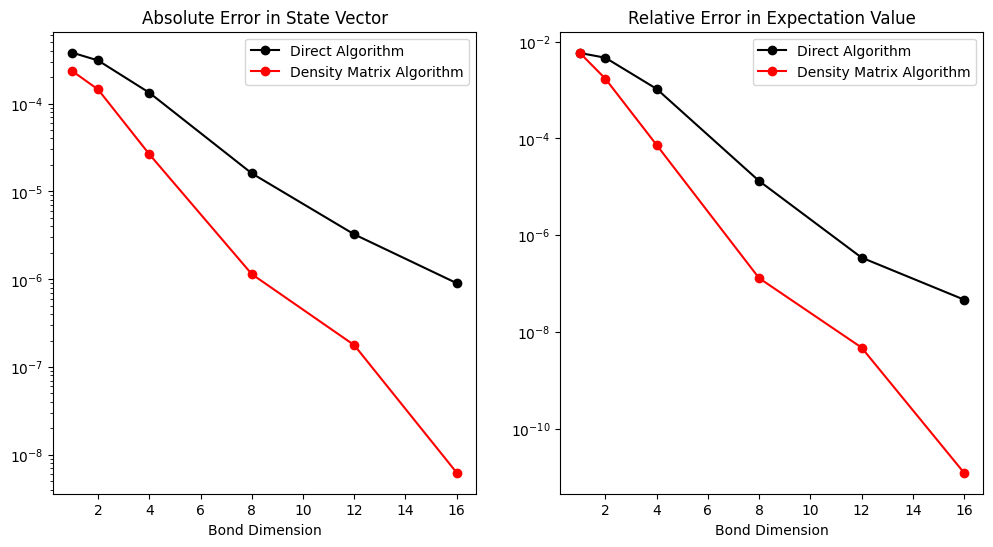

In [11]:
err_direct = []
err_dm = []

for max_extent in (1, 2, 4, 8, 12, 16):
    svd_setting = {'rel_cutoff': 1e-10, 'max_extent': max_extent}
    
    # 1. Using direct algorithm
    svd_method_direct = tensor.SVDMethod(partition='V', **svd_setting)
    new_mps_direct = multiply_mps_mpo_direct(mps_tensors, mpo_tensors, svd_method_direct, canonical_center=canonical_center, options=options)
    
    # 1a. compute the equivalent state vector
    mps_mpo_sv_direct = mps_helper.contract_state_vector(new_mps_direct, options=options)
    err_sv_direct = abs(mps_mpo_sv_direct - mps_mpo_sv_ref).max()
    
    # 1b. compute the expectation value with normalization
    expec_direct = contract('ipj,iPj,Pp->', new_mps_direct[operator_site], new_mps_direct[operator_site].conj(), one_body_operator, options=options) 
    expec_direct /= cp.linalg.norm(new_mps_direct[operator_site]) ** 2
    err_expec_direct = abs(1-expec_direct/expec_direct_full)
    
    # 2. Using density matrix algorithm
    svd_method_dm = tensor.SVDMethod(**svd_setting)
    new_mps_dm = multiply_mps_mpo_density_matrix(mps_tensors, mpo_tensors, svd_method_dm, canonical_center=canonical_center, options=options)
    
    # 2a. compute the equivalent state vector
    mps_mpo_sv_dm = mps_helper.contract_state_vector(new_mps_dm, options=options)
    err_sv_dm = abs(mps_mpo_sv_dm - mps_mpo_sv_ref).max()
    
    # 2b. compute the expectation value with normalization
    expec_dm = contract('ipj,iPj,Pp->', new_mps_dm[operator_site], new_mps_dm[operator_site].conj(), one_body_operator, options=options) 
    expec_dm /= cp.linalg.norm(new_mps_dm[operator_site]) ** 2
    err_expec_dm = abs(1-expec_dm/expec_dm_full)
    
    err_direct.append([max_extent, err_sv_direct.get(), err_expec_direct.get()])
    err_dm.append([max_extent, err_sv_dm.get(), err_expec_dm.get()])

err_direct = np.asarray(err_direct)
err_dm = np.asarray(err_dm)

# making plots
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(12,6), sharex=True)
direct_plot_kwargs = {'color': 'k',
                      'marker': 'o',
                      'label': 'Direct Algorithm'}

dm_plot_kwargs = {'color': 'r',
                  'marker': 'o',
                  'label': 'Density Matrix Algorithm'}

axes[0].plot(err_direct[:,0], err_direct[:,1], **direct_plot_kwargs)
axes[0].plot(err_dm[:,0], err_dm[:,1], **dm_plot_kwargs)
axes[0].set_yscale('log')
axes[0].legend()
axes[0].set_xlabel('Bond Dimension')
axes[0].set_title('Absolute Error in State Vector')

axes[1].plot(err_direct[:,0], err_direct[:,2], **direct_plot_kwargs)
axes[1].plot(err_dm[:,0], err_dm[:,2], **dm_plot_kwargs)
axes[1].set_yscale('log')
axes[1].legend()
axes[1].set_xlabel('Bond Dimension')
axes[1].set_title('Relative Error in Expectation Value')
plt.show()


In [12]:
# Remember that we need to free the library handle in the end
cutn.destroy(handle)